# INFO2950 Phase 4: Logistic Regression

In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf

In [2]:
data_dir = "../data"

In this notebook, we will be performing logistic regression on the merged Instagram and scorecard data. We hope to see if there's a relationship between Instagram statistics and some binary outputs/characteristics of associated colleges and universities. More specifically, can follower statistics predict things about an institution such as selectivity, student family income, cost of attendance, and locale type?

In [30]:
instagram_details = pd.read_csv(os.path.join(data_dir, "instagram_details.csv"))
instagram_details.dropna(subset=["name"])
instagram_details.head()

,name,instagram,follower_curr,follower_mean,follower_med,follower_std,follower_min,follower_max,following_curr,following_mean,...,income_med,size,lat,lon,city,ownership,region,state,locale_type,locale_size
0,Amherst College,amherstcollege,17800.0,15857.662338,15600.0,959.139013,14200.0,17800.0,650.0,636.251948,...,42053.0,1855.0,42.372459,-72.518493,Amherst,private non-profit,new england,MA,suburb,large
1,Arizona State University-Tempe,arizonastateuniversity,118900.0,105752.835052,104450.0,7242.379383,94100.0,118900.0,1523.0,1545.634021,...,35851.0,42529.0,33.417721,-111.934383,Tempe,public,southwest,AZ,city,medium
2,Boston College,bostoncollege,98600.0,92220.822622,92100.0,3247.227738,85500.0,98600.0,301.0,267.388175,...,103007.0,9639.0,42.336213,-71.169242,Chestnut Hill,private non-profit,new england,MA,city,small
3,Boston University,bostonu,108200.0,91363.868613,91500.0,4608.620804,82800.0,108200.0,2775.0,2568.832117,...,81244.0,17238.0,42.351118,-71.107942,Boston,private non-profit,new england,MA,city,large
4,Bowdoin College,bowdoincollege,18500.0,16983.629893,17100.0,939.613708,15100.0,18500.0,1542.0,1512.483986,...,61622.0,1825.0,43.907134,-69.963942,Brunswick,private non-profit,new england,ME,town,large


In [4]:
instagram_details.columns

Index(['name', 'instagram', 'follower_curr', 'follower_mean', 'follower_med',
       'follower_std', 'follower_min', 'follower_max', 'following_curr',
       'following_mean', 'following_med', 'following_std', 'following_min',
       'following_max', 'posts_curr', 'posts_mean', 'posts_med', 'posts_std',
       'posts_min', 'posts_max', 'admission_rate', 'sat_score',
       'cost_attendance', 'income_avg', 'income_med', 'size', 'lat', 'lon',
       'city', 'ownership', 'region', 'state', 'locale_type', 'locale_size'],
      dtype='object')

We extract predictor columns often, so here we are refactoring it to a function. This also allows us to easily change the variables to see if we can get a better predictors.

In [5]:
def get_predictors(df):
    # return df[["follower_curr", "follower_mean", "follower_med", "follower_std", "follower_max", "follower_min"]]
    return df[["follower_curr", "follower_med", "follower_min"]]

According to the linear regressions performed in the other notebook, follower percent increase was effectively random in relation to scoreboard data. Empirical testing in this notebook also seems to suggest that it isn't a great predictor, so we just commented it out.

In [6]:
binary_data_predictors = get_predictors(instagram_details)
# binary_data_predictors = binary_data_predictors.assign(follower_percent_increase = (binary_data_predictors.follower_max - binary_data_predictors.follower_min) / binary_data_predictors.follower_min * 100)
binary_data_predictors.head()

,follower_curr,follower_med,follower_min
0,17800.0,15600.0,14200.0
1,118900.0,104450.0,94100.0
2,98600.0,92100.0,85500.0
3,108200.0,91500.0,82800.0
4,18500.0,17100.0,15100.0


Here, we isolate the output variables we think would be interested to try to predict. But first, we need to turn them into binary outputs.

In [7]:
output_data = instagram_details[["admission_rate", "income_med", "cost_attendance", "locale_type"]]
output_data.head()

,admission_rate,income_med,cost_attendance,locale_type
0,0.1281,42053.0,71300.0,suburb
1,0.8478,35851.0,25621.0,city
2,0.2789,103007.0,70588.0,city
3,0.2209,81244.0,70216.0,city
4,0.1026,61622.0,68070.0,town


To convert the values in the admission rate, income average, and cost of attendance columns to binary outputs, we calculate the entire sample's medians and create new columns with binary values (True/False) for whether the respective variable was above the sample's median.  
To convert locale type to binary outputs, we categorize each row as city vs. not-city and put those values in an additional column.

Note that there are biases in this data; this sample only consists of colleges that Changyuan was interested in. So, for example, there may be a skew towards more selective or urban institutions. Thus, this sample is only representative of the colleges/universities we have Instagram data for, not all the instutions in the United States.

In [8]:
admission_rate_med = output_data.admission_rate.median()
print("Median Admission Rate: {:.2f}%".format(admission_rate_med * 100))

income_med_med = output_data.income_med.median()
print("Median Income Average: ${:d}".format(int(income_med_med)))

cost_attendance_med = output_data.cost_attendance.median()
print("Median Cost of Attendance: ${:d}".format(int(cost_attendance_med)))

binary_city = output_data.locale_type == "city"
city_fraction = sum(binary_city) / len(binary_city)
print("Percent City: {:.2f}%".format(city_fraction * 100))

Median Admission Rate: 17.33%
Median Income Average: $63463
Median Cost of Attendance: $68901
Percent City: 61.43%


In [68]:
above_med_admission_rate = output_data.admission_rate > admission_rate_med
above_med_income_med = output_data.income_med > income_med_med
above_med_cost_attendance = output_data.cost_attendance > cost_attendance_med

binary_data = pd.DataFrame({"above_med_admission_rate": above_med_admission_rate,
                            "above_med_income_med": above_med_income_med,
                            "above_med_cost_attendance": above_med_cost_attendance,
                            "binary_city": binary_city})
binary_data.head()

,above_med_admission_rate,above_med_income_med,above_med_cost_attendance,binary_city
0,False,False,True,False
1,True,False,False,True
2,True,True,True,True
3,True,True,True,True
4,False,False,False,False


Here, we split the data to test the significance of our model's predictions. We are training the model on a random 80% of the data, and testing it on the rest.

In [10]:
data = binary_data_predictors.join(binary_data)
data_split = train_test_split(data, test_size=0.2)

data_train = data_split[0]
data_test = data_split[1]
data_test.head()

,follower_curr,follower_med,follower_min,above_med_admission_rate,above_med_income_med,above_med_cost_attendance,binary_city
67,17000.0,14900.0,13400.0,False,False,False,False
4,18500.0,17100.0,15100.0,False,False,False,False
13,13800.0,12400.0,10900.0,True,False,False,True
32,72400.0,58000.0,37900.0,False,False,False,False
24,86400.0,80050.0,70000.0,False,True,True,True


We are finally fitting the logistic regression model to the training data! There is one model for each output variable. We've printed the slopes and scores for each model.

In [11]:
n = 1000

In [12]:
def test_model(output, train):
    model = LogisticRegression(max_iter=n).fit(get_predictors(train), train[output])
    return model
def print_slope_score(model, test, output):
    print(output, "slope: {:.7f}".format(model.coef_[0,0]))
    print(output, "score: {:.2f}".format(model.score(get_predictors(test), test[output])))

In [13]:
selectivity_model = test_model("above_med_admission_rate", data_train)
income_model = test_model("above_med_income_med", data_train)
cost_model = test_model("above_med_cost_attendance", data_train)
city_model = test_model("binary_city", data_train)

print_slope_score(selectivity_model, data_test, "above_med_admission_rate")
print_slope_score(income_model, data_test, "above_med_income_med")
print_slope_score(cost_model, data_test, "above_med_cost_attendance")
print_slope_score(city_model, data_test, "binary_city")

above_med_admission_rate slope: -0.0000248
above_med_admission_rate score: 0.57
above_med_income_med slope: -0.0000002
above_med_income_med score: 0.86
above_med_cost_attendance slope: 0.0000240
above_med_cost_attendance score: 0.50
binary_city slope: 0.0001371
binary_city score: 0.43


Here, we manually calculate the percent accuracy of the prediction on the test data. The values below correctly match the scores above.

In [14]:
def percent_accuracy(prediction, actual):
    accurate = prediction == actual
    return sum(accurate) / len(accurate) * 100
def prediction_percent_accuracy(model, test, output):
    prediction = model.predict(get_predictors(test))
    accuracy = percent_accuracy(prediction, test[output])
    return accuracy
def print_accuracy(output, accuracy):
    print(output, "prediction accuracy: {:.1f}%".format(accuracy))

In [15]:
selectivity_accuracy = prediction_percent_accuracy(selectivity_model, data_test, "above_med_admission_rate")
income_accuracy = prediction_percent_accuracy(income_model, data_test, "above_med_income_med")
cost_accuracy = prediction_percent_accuracy(cost_model, data_test, "above_med_cost_attendance")
city_accuracy = prediction_percent_accuracy(city_model, data_test, "binary_city")

print_accuracy("above_med_admission_rate", selectivity_accuracy)
print_accuracy("above_med_income_med", income_accuracy)
print_accuracy("above_med_cost_attendance", cost_accuracy)
print_accuracy("binary_city", city_accuracy)

above_med_admission_rate prediction accuracy: 57.1%
above_med_income_med prediction accuracy: 85.7%
above_med_cost_attendance prediction accuracy: 50.0%
binary_city prediction accuracy: 42.9%


We want to run this many times (denoted by the variable `n`) to ensure that the prediction accuracy wasn't just due to a lucky sampling of training data. So, we put everything we did above into a function, `log_model`.

In [16]:
def log_model(data):
    data_split = train_test_split(data, test_size=0.2)

    data_train = data_split[0]
    data_test = data_split[1]
    
    selectivity_model = test_model("above_med_admission_rate", data_train)
    income_model = test_model("above_med_income_med", data_train)
    cost_model = test_model("above_med_cost_attendance", data_train)
    city_model = test_model("binary_city", data_train)
    
    predictor = get_predictors(data_test)
    selectivity_accuracy = selectivity_model.score(predictor, data_test["above_med_admission_rate"])
    income_accuracy = income_model.score(predictor, data_test["above_med_income_med"])
    cost_accuracy = income_model.score(predictor, data_test["above_med_cost_attendance"])
    city_accuracy = city_model.score(predictor, data_test["binary_city"])
    
    return selectivity_accuracy, income_accuracy, cost_accuracy, city_accuracy

Then, we run it `n` times and calculate the median of the accuracy. An accuracy over 0.5 means the prediction was (on median) better than a binary guess.

In [48]:
selectivity_accuracies = np.zeros(n)
income_accuracies = np.zeros(n)
cost_accuracies = np.zeros(n)
city_accuracies = np.zeros(n)

for i in range(n):
    run_model = log_model(data)
    selectivity_accuracies[i] = run_model[0]
    income_accuracies[i] = run_model[1]
    cost_accuracies[i] = run_model[2]
    city_accuracies[i] = run_model[3]

print("Selectivity accuracy median: {:.2f}".format(np.median(selectivity_accuracies)))
print("Income accuracy median: {:.2f}".format(np.median(income_accuracies)))
print("Cost accuracy median: {:.2f}".format(np.median(cost_accuracies)))
print("City accuracy median: {:.2f}".format(np.median(city_accuracies)))

Selectivity accuracy median: 0.57
Income accuracy median: 0.50
Cost accuracy median: 0.50
City accuracy median: 0.57


It seems like the follower data can reasonably predict whether a school is selective and if its locale is city or not, but not student family income or cost of attendance.

Finally, we plot the accuracies to see the distribution across all `n` runs. There doesn't seem to be anything too surprising in terms of skew or kurtosis.

In [18]:
def plot_accuracies(accuracy, title):
    plt.hist(accuracy, bins=10)
    plt.xlabel("accuracy")
    plt.ylabel("frequency")
    plt.title(title)
    plt.show()

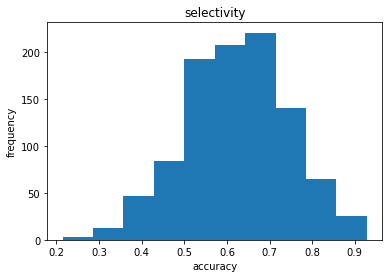

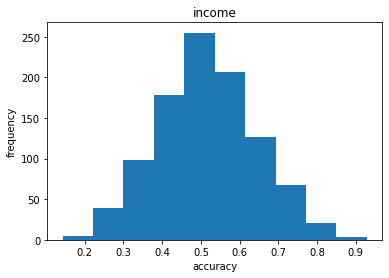

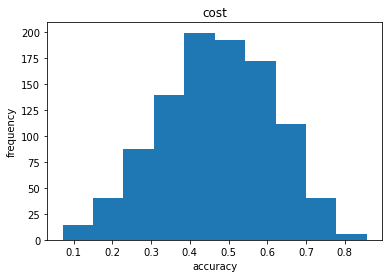

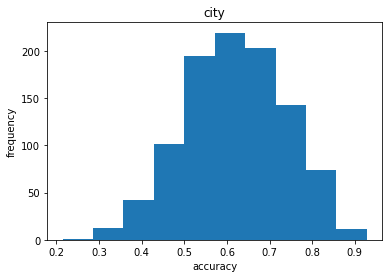

In [49]:
plot_accuracies(selectivity_accuracies, "selectivity")
plot_accuracies(income_accuracies, "income")
plot_accuracies(cost_accuracies, "cost")
plot_accuracies(city_accuracies, "city")

We thought the model might be improved if we removed a few outliers we found in our previous explorations. We took out Harvard, Stanford, and Yale.

In [42]:
outliers = {"Harvard University", "Stanford University", "Yale University"}
instagram_details = instagram_details[~instagram_details.name.isin(outliers)]

binary_data_predictors = get_predictors(instagram_details)

admission_rate_med = instagram_details.admission_rate.median()
income_med_med = instagram_details.income_med.median()
cost_attendance_med = instagram_details.cost_attendance.median()
binary_city = instagram_details.locale_type == "city"

above_med_admission_rate = instagram_details.admission_rate > admission_rate_med
above_med_income_med = instagram_details.income_med > income_med_med
above_med_cost_attendance = instagram_details.cost_attendance > cost_attendance_med

binary_data = pd.DataFrame({"above_med_admission_rate": above_med_admission_rate,
                            "above_med_income_med": above_med_income_med,
                            "above_med_cost_attendance": above_med_cost_attendance,
                            "binary_city": binary_city})

filtered_data = binary_data_predictors.join(binary_data)
filtered_data.head()

,follower_curr,follower_med,follower_min,above_med_admission_rate,above_med_income_med,above_med_cost_attendance,binary_city
0,17800.0,15600.0,14200.0,False,False,True,False
1,118900.0,104450.0,94100.0,True,False,False,True
2,98600.0,92100.0,85500.0,True,True,True,True
3,108200.0,91500.0,82800.0,True,True,True,True
4,18500.0,17100.0,15100.0,False,False,False,False


Then, we ran the same code as before on the filtered data.

Selectivity accuracy median: 0.50


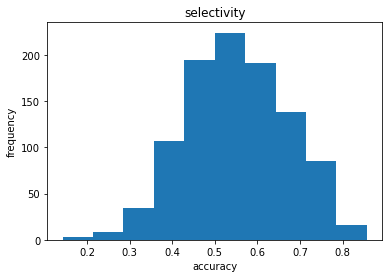

Income accuracy median: 0.50


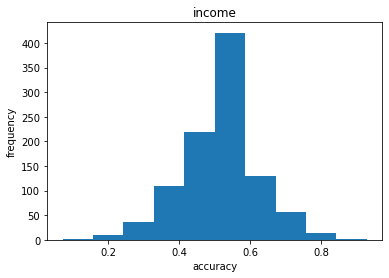

Cost accuracy median: 0.50


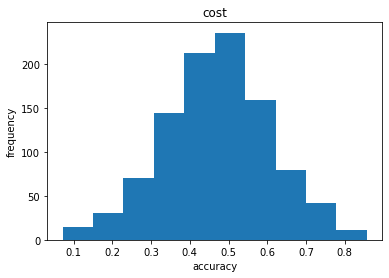

City accuracy median: 0.57


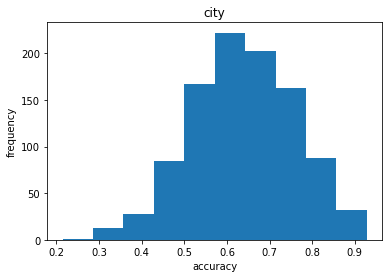

In [47]:
for i in range(n):
    run_model = log_model(filtered_data)
    selectivity_accuracies[i] = run_model[0]
    income_accuracies[i] = run_model[1]
    cost_accuracies[i] = run_model[2]
    city_accuracies[i] = run_model[3]

print("Selectivity accuracy median: {:.2f}".format(np.median(selectivity_accuracies)))
plot_accuracies(selectivity_accuracies, "selectivity")

print("Income accuracy median: {:.2f}".format(np.median(income_accuracies)))
plot_accuracies(income_accuracies, "income")

print("Cost accuracy median: {:.2f}".format(np.median(cost_accuracies)))
plot_accuracies(cost_accuracies, "cost")

print("City accuracy median: {:.2f}".format(np.median(city_accuracies)))
plot_accuracies(city_accuracies, "city")

To our surprise, removing outliers didn't affect the data as much as we thought it would. One possibility is because those institutions are mainly outliers in popularity rather than outliers as institutions, and are predicted by our logistic regression models similarly to other schools.

In [70]:
# smf.logit(binary_data_predictors, above_med_admission_rate).fit()

PatsyError: model is missing required outcome variables